# Evaluation of segmentation MCD model

In [1]:
from loss_functions import Dice_coef, dice_coef, dice_loss, dice_score
from matplotlib.colors import  LinearSegmentedColormap
from skimage.transform import resize, downscale_local_mean, rescale
from skimage.restoration import denoise_nl_means, estimate_sigma
from tensorflow.keras.utils import to_categorical
from tfk_instance_norm import InstanceNormalization
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
from random import randint
from skimage import transform
import tensorflow as tf
import pandas as pd
import nibabel as nib
import numpy as np
import utils as ut
import scipy
import os 
import seaborn as sns

import scipy.signal as signal
import numpy as np
import cv2
import random


tran = 0.8
colorsM = [(0, 0, 0, 0), (1,  0.30196078,  0., tran), (1  ,  0.39,  0.39, tran)]  # (R,G,B,T)
cmap_name = 'my_list'
cmc = LinearSegmentedColormap.from_list(cmap_name, colorsM, N=3)

/Users/elena/miniconda3/envs/aicuram/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Functions to load the data and normalise segmentation mask
def norm_label(y):
    label = np.copy(y)
    for i in range(len(np.unique(label))):
        label[label == np.unique(label)[i]] = i
    return label

def prepare_y(y):
    y = norm_label(y)
    return to_categorical(y, output_classes)


def load_file1(path_array):
    while True:
        try:
            volume = ut.get_random_sample(path_array, batch_size=1)
            break
        except:
            continue
    return volume.transpose([1,2,3,4,0])


# Training and validation loss & metric results

In [6]:
df = pd.read_csv("/Users/elena/aicura/segmentation/wmh/thesis_elena/unet/mcd/models/each_fold.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   epoch           1500 non-null   int64  
 1   dice_score      1500 non-null   float64
 2   loss            1500 non-null   float64
 3   val_dice_score  1500 non-null   float64
 4   val_loss        1500 non-null   float64
 5   fold            1500 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 70.4 KB


In [134]:
df.fold = pd.Categorical(df.fold, ordered=False)


In [7]:
df_mean = df.groupby(['fold'], as_index=False).mean()[['fold', 'dice_score', 'loss', "val_dice_score", 'val_loss']]
df_std = df.groupby(['fold'], as_index=False).std()[['fold', 'dice_score', 'loss', "val_dice_score", 'val_loss']]


In [8]:
df_mean

,fold,dice_score,loss,val_dice_score,val_loss
0,1,0.758836,0.241164,0.750119,0.249881
1,2,0.759664,0.240336,0.750416,0.249584
2,3,0.757793,0.242207,0.736489,0.263511
3,4,0.768463,0.231537,0.729655,0.270345
4,5,0.759771,0.240229,0.748998,0.251002


In [9]:
df_mean.dice_score.mean()

0.7609054630200001

In [139]:
df_std

,fold,dice_score,loss,val_dice_score,val_loss
0,1,0.092968,0.092968,0.084218,0.084218
1,2,0.092493,0.092493,0.073085,0.073085
2,3,0.095800,0.095800,0.077939,0.077939
3,4,0.092729,0.092729,0.066124,0.066124
4,5,0.093236,0.093236,0.086788,0.086788


In [10]:
df_loss = df.pivot(index='epoch', columns='fold', values='loss')
df_loss['avg'] = df_loss.mean(axis=1)
df_loss = df_loss.reset_index()
df_val_los = df.pivot(index='epoch', columns='fold', values='val_loss')
df_val_los['avg'] = df_val_los.mean(axis=1)
df_val_los = df_val_los.reset_index()
df_dice = df.pivot(index='epoch', columns='fold', values='dice_score')
df_dice['avg'] = df_dice.mean(axis=1)
df_dice = df_dice.reset_index()
df_val_dice = df.pivot(index='epoch', columns='fold', values='val_dice_score')
df_val_dice['avg'] = df_val_dice.mean(axis=1)
df_val_dice = df_val_dice.reset_index()


In [11]:
data = [df_loss['avg'], df_val_los['avg'], df_dice['avg'], df_val_dice['avg']]
data = np.array(data)


In [12]:
df_final = pd.DataFrame({'Loss': data[0, :], 'Val_Loss': data[1, :], 'Dice_Score' : data[2, :], 'Val_Dice_Score' : data[3, :]})

In [149]:
df_final.head()

,Loss,Val_Loss,Dice_Score,Val_Dice_Score
0,0.655867,0.653102,0.344133,0.346898
1,0.652136,0.645716,0.347864,0.354284
2,0.641049,0.634032,0.358951,0.365968
3,0.629813,0.617534,0.370187,0.382466
4,0.608539,0.597498,0.391461,0.402502


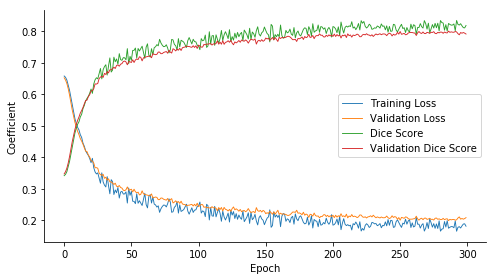

In [13]:

df_final.plot(figsize=(7,4), lw=0.9)
plt.legend(['Training Loss', 'Validation Loss', 'Dice Score', 'Validation Dice Score'])
plt.xlabel('Epoch')
plt.ylabel('Coefficient')
sns.despine(left=False, bottom=False, top=True, right=True)

plt.tight_layout()
plt.savefig('training.pdf')

plt.show()

# Evaluation

## Loading of the data

In [3]:
b = np.loadtxt('paths/1test_ids.txt', dtype=str)
path_array = np.char.replace(b, "/opt/Lesion_Segmentation/data/wmls/elena_thesis/", "/Users/elena/Documents/data/thesis_data/train/")

In [18]:
path_array.shape

(3, 21)

In [4]:
input_shape = (128, 128, 128, 1)
x_dim = input_shape[0] 
y_dim = input_shape[1]
z_dim = input_shape[2]


output_classes = 2

x_data, y_data, orig = [], [], []
for _ in range(0,21):
    print(path_array[2,_])
    # Load the data
    flair = nib.load(path_array[1,_])
    flair = np.array(flair.dataobj) 
    t1 = nib.load(path_array[0,_])
    t1 = np.array(t1.dataobj) 
    lab = nib.load(path_array[2,_])
    label_ar = np.array(lab.dataobj).astype("float32") 
    flair = np.squeeze(flair)
    t1 = np.squeeze(t1)

    # cropping
    mask = ut.thr_cuboid(flair)
    flair,t1,label, indx = ut.get_cuboid_DR(flair, t1,label_ar, mask) 
    # bi-cubic interpolation
    x = resize(flair,[128, 128, 128],order=3,anti_aliasing=True)
    x_t1 = resize(t1,[128, 128, 128],order=3,anti_aliasing=True)
    
    
    x = np.stack((x, x_t1), axis=3)
    x = ut.rescale(x,max=255) # intensity normalisation
    x = np.expand_dims(x, axis=0)

    y = resize(label,[128, 128, 128],preserve_range=True)
    # Threschold the data
    th = 0.3
    y[y>=th] = 1
    y[y<th] = 0

    y = prepare_y(y)
    y = np.expand_dims(y, axis=0)
    x_data.append(x)
    y_data.append(y)
    

x_data = np.array(x_data)
print('-->final x shape: {}'.format(x_data.shape))
y_data = np.array(y_data)
print('-->final y shape: {}'.format(y_data.shape))


/Users/elena/Documents/data/thesis_data/train/MS17/28/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MS17/6/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MS17/7/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MS17/22/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MS17/26/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MS17/9/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MS17/2/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MICCAI17/Singapore/59/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MICCAI17/Singapore/61/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MICCAI17/Singapore/63/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MICCAI17/Singapore/56/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MICCAI17/Singapore/51/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MICCAI17/GE3T/109/wmh.nii.gz
/Users/elena/Documents/data/thesis_data/train/MICCAI17/GE3T/115/wmh.nii.gz
/Use

In [215]:
x_data.shape

(21, 1, 128, 128, 128, 2)

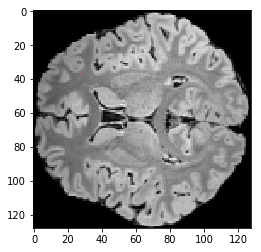

In [59]:
plt.imshow(x_data[3,0,:,:,68,1], "gray")
plt.imshow(y_data[3,0,:,:,68,1], cmc)
plt.show()

In [8]:
y_test = np.squeeze(y_data,axis=1)
x_test = np.squeeze(x_data,axis=1)

### Loading of the model

In [11]:
def get_model_path_list(model_dir):
    b_model = []
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            file_path = subdir + '/' + file # change to '\\' if using Windows
            if file_path.endswith("best_model.hdf5"): # change to '\\' if using Windows
                b_model.append(file_path) 
    return np.array([np.array(b_model)])

In [12]:
model_path = '/Users/elena/aicura/segmentation/wmh/thesis_elena/unet/mcd/mcd_models'

model_path_array = get_model_path_list(model_path)
model_path_array.shape

(1, 5)

In [9]:
model_path_array[0,1]

'/Users/elena/aicura/segmentation/wmh/thesis_elena/unet/mcd/models/1_fold_best_model.hdf5'

In [13]:
model = load_model(model_path_array[0,1], custom_objects={'dice_loss': dice_loss, 'dice_score':dice_score, 'InstanceNormalization':InstanceNormalization})

# Evaluation of the 5 fold Cross-Validation

### Evaluation results

In [27]:
evals1 = [model.evaluate(x_test[i:i+1], y_test[i:i+1]) for i in range(len(x_test))]

1/1 [==============================] - 5s 5s/sample - loss: 0.1849 - dice_score: 0.8151


In [28]:
evals1 = np.array(evals1)
np.savetxt("models/"+str(1)+'_evals_mcd.txt', evals1, fmt='%1.4f')

In [41]:
evals2 = [model.evaluate(x_test[i:i+1], y_test[i:i+1]) for i in range(len(x_test))]

1/1 [==============================] - 5s 5s/sample - loss: 0.2054 - dice_score: 0.7946


In [42]:
evals2 = np.array(evals2)
np.savetxt("models/"+str(2)+'_evals_mcd.txt', evals2, fmt='%1.4f')

In [48]:
evals3 = [model.evaluate(x_test[i:i+1], y_test[i:i+1]) for i in range(len(x_test))]

1/1 [==============================] - 4s 4s/sample - loss: 0.2058 - dice_score: 0.7942


In [49]:
evals3 = np.array(evals3)
np.savetxt("models/"+str(3)+'_evals_mcd.txt', evals3, fmt='%1.4f')

In [57]:
evals4 = [model.evaluate(x_test[i:i+1], y_test[i:i+1]) for i in range(len(x_test))]

1/1 [==============================] - 4s 4s/sample - loss: 0.1063 - dice_score: 0.8937


In [60]:
evals4 = np.array(evals4)
np.savetxt("models/"+str(4)+'_evals_mcd.txt', evals4, fmt='%1.4f')

In [66]:
evals5 = [model.evaluate(x_test[i:i+1], y_test[i:i+1]) for i in range(len(x_test))]

1/1 [==============================] - 4s 4s/sample - loss: 0.1218 - dice_score: 0.8782


In [67]:
evals5 = np.array(evals5)
np.savetxt("models/"+str(5)+'_evals_mcd.txt', evals5, fmt='%1.4f')

## Mean Dice on test samples 

In [68]:
evals1[:,1].mean()

0.8199618657430013

In [69]:
evals2[:,1].mean()

0.8333066389674232

In [70]:
evals3[:,1].mean()

0.812357763449351

In [71]:
evals4[:,1].mean()

0.8207959873335702

In [72]:
evals5[:,1].mean()

0.8125841135070437

In [2]:
avg = np.array([0.8199618657430013,0.8333066389674232,0.812357763449351,0.8207959873335702, 0.8125841135070437])

In [3]:
avg.mean()

0.819801273800078

### Visual assessment of the predicted lesions

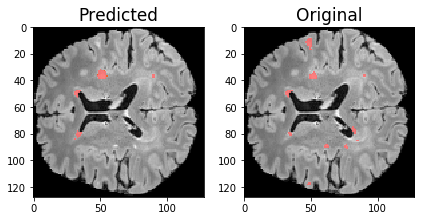

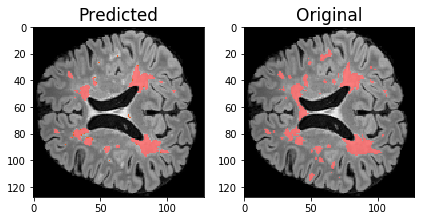

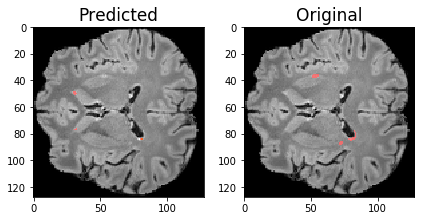

In [341]:
for i in range(0, 3):
    scores = model.predict(x_data[i])
    # Create figure and plot space
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x_data[i][0,:,:,75,1], "gray")
    ax[0].imshow(scores[0,:,:,75,1], cmc)
    ax[0].axes.set_title("Predicted",fontsize=17)

    ax[1].imshow(x_data[i][0,:,:,75,1], "gray")
    ax[1].imshow(y_data[i][0,:,:,75,1], cmc)
    ax[1].axes.set_title("Original",fontsize=17)

    plt.tight_layout()

    plt.savefig(str(i) + '_example.pdf')
    plt.show()

## Uncertainty

In [14]:
from tqdm import tqdm
import time

## Entropy

In [15]:
def entropy_calc(X,gt,model,bz,sample_times):

    # initialize our predictions
    Y_hat = np.zeros(shape = (sample_times,X.shape[1],X.shape[2],X.shape[3],2),dtype='float32')
    start = time.time() # MC dropout is starting
    percentage = []
    for sample_id in range(sample_times):
        # predict stochastic dropout model T times
        Y_hat[sample_id] = model.predict(X, bz)
        y = Y_hat[sample_id]
        y = y[:,:,:,1]
        y[y>=0.5] = 1
        y[y<0.5] = 0
        unc_vol = np.sum(y > 0)
        perc = unc_vol*100/np.sum(X[:, :, :, :, 0])
        perc = np.around(perc, decimals=5)
        percentage.append(perc)
    # average over all passes
    prediction = Y_hat.mean(axis=0)
    gt_sum = np.sum(gt[:, :, :, :, 1])
    gt_perc = gt_sum*100/np.sum(X[:, :, :, :, 0])
    loss, dice = model.evaluate(X, gt, batch_size=1, verbose=0)
    #prediction = prediction[:,:,:,1]
    uncertainty_mc = -(prediction*np.log2(prediction+1e-7) + (1-prediction)*np.log2(1-prediction+1e-7)) ## entropy = -(p*np.log2(p) + (1-p)*np.log(1-p))
    end = time.time()        
    chkpnt = (end-start) 
    print("\n Time needed for MC Dropout-based Uncertainty Estimation  ",chkpnt)
    threshold=0.5
    prediction[prediction<threshold]=0
    prediction[prediction>=threshold]=1
    return Y_hat, prediction, uncertainty_mc, dice, percentage, gt_perc

In [55]:
scores = model.predict(x_data[1])

In [279]:
x = x_data[1:20]
y = y_data[1:20]

In [29]:
x.shape[5]

2

In [16]:
prediction, entropy_unc, dice_values, perc, gt_perc, mc = [], [], [], [], [], []
for i in range(x_data.shape[0]):
    MC_maps, pred, unc_map, dice, percentage, gt_percentage = entropy_calc(x_data[i], y_data[i], model, 1, sample_times=20)
    prediction.append(pred)
    entropy_unc.append(unc_map)
    dice_values.append(dice)
    perc.append(percentage)
    gt_perc.append(gt_percentage)
    mc.append(MC_maps)



 Time needed for MC Dropout-based Uncertainty Estimation   152.30029273033142

 Time needed for MC Dropout-based Uncertainty Estimation   137.4391040802002

 Time needed for MC Dropout-based Uncertainty Estimation   132.7635281085968

 Time needed for MC Dropout-based Uncertainty Estimation   97.94366693496704

 Time needed for MC Dropout-based Uncertainty Estimation   99.35818409919739

 Time needed for MC Dropout-based Uncertainty Estimation   91.21654200553894

 Time needed for MC Dropout-based Uncertainty Estimation   89.1061692237854

 Time needed for MC Dropout-based Uncertainty Estimation   87.99846911430359

 Time needed for MC Dropout-based Uncertainty Estimation   86.98626613616943

 Time needed for MC Dropout-based Uncertainty Estimation   93.37176012992859

 Time needed for MC Dropout-based Uncertainty Estimation   89.1524088382721

 Time needed for MC Dropout-based Uncertainty Estimation   90.67185807228088

 Time needed for MC Dropout-based Uncertainty Estimation   88.51

In [17]:
perc = np.array(perc)

In [18]:
gt_perc = np.array(gt_perc)
gt_perc = np.around(gt_perc, decimals=5)


### Predicted vs. GT wmh volume % 

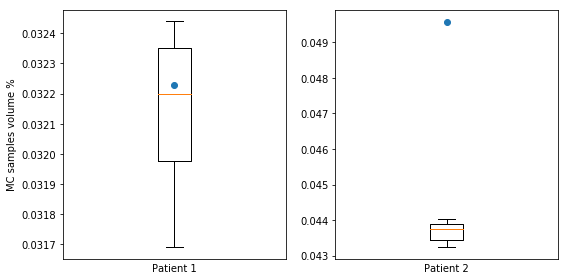

In [334]:
from matplotlib import ticker

fig, axes = plt.subplots(1,2,figsize=(8,4))

axes[0].boxplot(perc[10])
axes[0].scatter(1, gt_perc[10])
axes[0].set_xlabel('Patient 1')
axes[0].set_ylabel('MC samples volume %')
axes[0].set_xticks([])

axes[1].boxplot(perc[11])
axes[1].scatter(1, gt_perc[11])
axes[1].set_xlabel('Patient 2')
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(8))
axes[1].set_xticks([])

plt.tight_layout()

plt.savefig('boxplot.pdf',bbox_inces='tight',dpi=100)

In [19]:
prediction = np.array(prediction)
entropy_unc = np.array(entropy_unc)
dice_values = np.array(dice_values)

In [336]:
entropy_unc.shape

(21, 128, 128, 128, 2)

### Aggregation of the uncertainty: Sum

In [20]:
unc_sum = []
for i in np.arange(0,21):
    value = (np.sum(entropy_unc[i,:,:,:,0]))
    unc_sum.append(value)

unc_sum = np.array(unc_sum)
print(unc_sum.shape)

(21,)


#### Correlation

In [21]:
import scipy.stats
statss = scipy.stats.pearsonr(dice_values, unc_sum)

In [22]:
statss

(0.5536859464631597, 0.009213703748059932)

#### Scatter plot

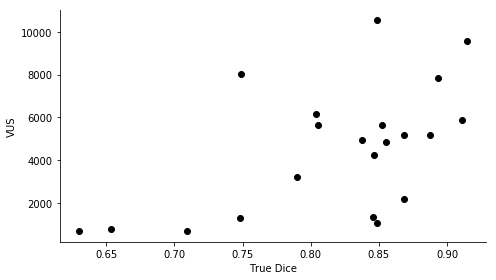

In [31]:
plt.figure(figsize=(7,4))
plt.plot(dice_values, unc_sum, 'o', color='black');
plt.xlabel('True Dice')
plt.ylabel('VUS')
sns.despine(left=False, bottom=False, top=True, right=True)
plt.tight_layout()
plt.savefig('VUSscatter.pdf')

### Filtering based on the summed uncertainty maps

In [385]:
unc_sum < 800

array([False, False,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False])

In [28]:
dice_filtered = dice_values[unc_sum > 800]

In [29]:
dplt.figure(figsize=(20,10))ice_values.mean()

0.8174826871781122

In [30]:
dice_filtered.mean()

0.8430371085802714

In [384]:
dice_filtered.shape

(18,)

### Aggregation: VVC

In [388]:
mc = np.array(mc)

In [389]:
mc.shape

(21, 20, 128, 128, 128, 2)

In [327]:
mean_vvc = []
for k in np.arange(0,19):
    var_coef = []
    mc_sample = mc[k]
    for i in np.arange(0,20):
        vvc = mc_sample[i].var()/mc_sample[i].mean()
        var_coef.append(vvc)
    var_coef = np.mean(np.array(var_coef))
    mean_vvc.append(var_coef)
    print('VVC is %s' % var_coef, k)
mean_vvc = np.array(mean_vvc)

VVC is 0.49986583 0
VVC is 0.4995211 1
VVC is 0.49997464 2
VVC is 0.49974498 3
VVC is 0.49990693 4
VVC is 0.4997405 5
VVC is 0.4999687 6
VVC is 0.49977174 7
VVC is 0.49981934 8
VVC is 0.49956232 9
VVC is 0.49973828 10
VVC is 0.49965543 11
VVC is 0.49996996 12
VVC is 0.49994326 13
VVC is 0.49977145 14
VVC is 0.4997712 15
VVC is 0.49978137 16
VVC is 0.49995527 17
VVC is 0.4999469 18


## Visualisation

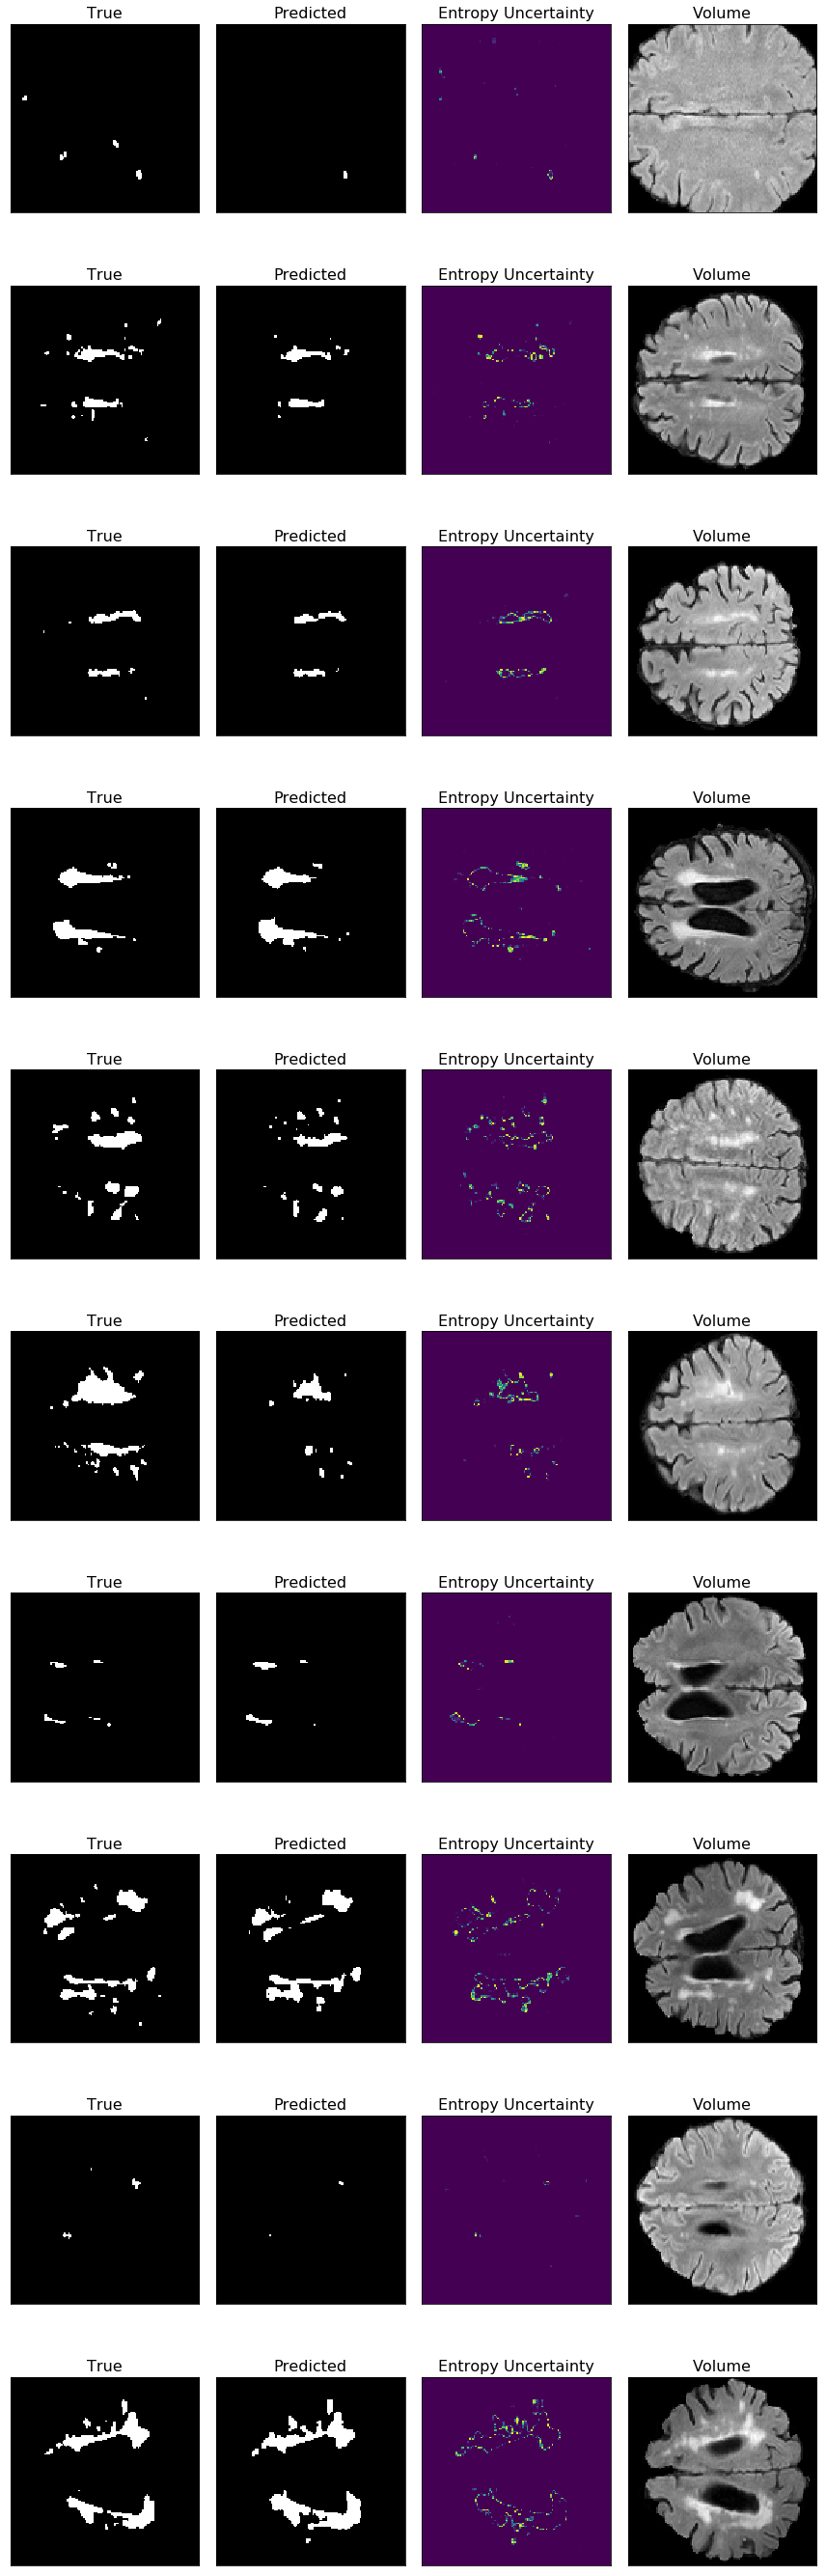

In [142]:
fig, axes = plt.subplots(10,4,figsize=(3*4,10*4))
for i in range(0,10):

    axes[i,0].imshow(y_data[i+6,0,:,:,88, 1], cmap='gray')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_title('True',{'fontsize':16})
    #axes[i,0].set_ylabel(well_ts[i],{'fontsize':16})
    
    axes[i,1].imshow(prediction[i+6,:,:,88,1], cmap='gray')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_title('Predicted',{'fontsize':16})
    
    axes[i,2].imshow(entropy_unc[i+6,:,:,88,1], cmap='viridis')
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].set_title('Entropy Uncertainty',{'fontsize':16})
    
    axes[i,3].imshow(x_data[i+6,0,:,:,88, 1], cmap='gray')
    axes[i,3].set_xticks([])
    axes[i,3].set_yticks([])
    axes[i,3].set_title('Volume',{'fontsize':16})
    plt.tight_layout()

plt.tight_layout()

plt.savefig('Uncertainty_1.png',bbox_inces='tight',dpi=100)